# Data Analyst Nanodegree OpenStreetMap Project
Author: Brian Novak

## Map Area
Around Baton Rouge, LA, United States.

## Problems Encountered in the Map

### Find types of tags, particularly ones with problematic characters.

In [1]:
run tag_types.py

{'lower': 72385, 'lower_colon': 117496, 'other': 11424, 'problemchars': 0}

0 tags were found with problematic characters


### Street Types

The code from lesson 6 of the course was used with some small modifications. This checks for abbreviations in the last word of the street names which is usually the type of street. Some additions were made to the expected street types and the mapping dictionary. When the last word in a street name could be represented as an integer, then that street name was ignored. This ignored 'Highway 16', 'Highway 42', and 'Highway 44' in this data set.

In [2]:
run improving_street_names.py

There are 95 streets in the data set

Street names with abbreviated types:

Essen Ln => Essen Lane
Equity Dr => Equity Drive
Burbank Dr => Burbank Drive
Juban Rd => Juban Road
Jefferson Hwy => Jefferson Highway
East Parker Blvd => East Parker Boulevard
O'Donovan Blvd => O'Donovan Boulevard
Hazelwood dr => Hazelwood Drive

8 street name abbreviations were found


### City Names

Since there were only a few cities in the data set, the names were just checked manually and none were found to be spelled incorrectly or abbreviated. Of course if analysis of multiple data sets or larger areas were to be done, it would be worth comparing the city names to a database such as GeoNames (<http://download.geonames.org/export/dump/cities1000.zip>). The cities in the data set were:

In [3]:
run find_city_names.py

Cities included in the data:

Gonzales
Baton Rouge
Denham Springs
Central
Walker
Slaughter
Watson
Brusly
Port Allen


### Zip Codes

The zip codes in the addr:postcode fields were checked against the GeoNames zip code data (<http://download.geonames.org/export/zip/US.zip>), to make sure they were consistent with the city name. No problems were found in the OSM data, but I noticed that the city of Central was missing from the GeoNames data. Central officially became a separate city from Baton Rouge in 2005, but the zip codes in that area remained as 70837. This was not a problem for checking the OSM data since there was only one entry for Central in it and it did not contain the addr:postcode field. Central was also added to the GeoNames data file.

In [4]:
run check_zip_codes.py

No problems with zip codes


### County (parish) id numbers

The GeoNames data also contains the names and id numbers of the counties or parishes in the case of Louisiana and an id number for them. Since the OSM records containing city names sometimes also contain the county id number, the county id numbers in the OSM records were checked to make sure they were consistent with the city names. Records containing both a city name and an id number for the county seem to be rare; there were only two in this data set and both were consistent.

In [5]:
run check_county_ids.py

No problems with county id numbers


### State name abbreviations

Although the state name abbreviations in the addr:state tag are unlikely to be incorrect, it is also easy to do a quick check. Instead of using python, grep can be used to pull out the lines to check and awk can be used to pull out the state abbreviations from the lines. All of the state name abbreviations are correct in the addr:state tags if the case is not considered. There are 4 entries where the second letter is 'a' instead of 'A'

In [6]:
%%bash

cat Baton_Rouge.osm | grep "addr:state" | awk '{print $3}' | \
awk -F= '{print $2}' | awk -F/ '{print $1}' | awk '$1 !~ "LA"'

"La"
"La"
"La"
"La"


### Consistency of Street Address with City and Latitude and Longitude 

Although the zip codes and cities are consistent in the OSM data, there is no guarantee that the street address is not actually in a different city with a different zip code. Although the data set was chosen by location, there is still a possibility that the latitude and longitude are inside the region of interest, but still not consistent with the street address. These things were not checked, but could be checked using reverse geocoding
(http://www.geonames.org/export/web-services.html#findNearbyPlaceName, https://developers.google.com/maps/documentation/geocoding/intro?csw=1#ReverseGeocoding).

### Apply fixes to street names and convert to JSON to be read into MongoDB

The code from the course was just used on my data set since no additional changes beyond street names were applied.

In [7]:
run preparing_for_database.py

### Import data into MongoDB using mongoimport

> mongod &

> mongoimport --file Baton_Rouge.osm.json -d OSM -c Baton_Rouge_LA_US_area

## Data Overview

### Size of original XML data set in MB

In [1]:
%%bash
ls -lh Baton_Rouge.osm | awk '{print $5}'

54M


### Total number of entries (mongo shell)

> db.Baton_Rouge_LA_US_area.count()

>> 260134

### Number of entries by city for entries with a city name (mongo shell)

> db.Baton_Rouge_LA_US_area.aggregate( [ { \$match: {"address.city": { \$exists: true } } }, { \$group: { _id: "\$address.city", count: { \$sum: 1} } }, { \$sort: { "count": -1 } } ] )

>> { "_id" : "Baton Rouge", "count" : 61 }

>> { "_id" : "Denham Springs", "count" : 10 }

>> { "_id" : "Gonzales", "count" : 4 }

>> { "_id" : "Walker", "count" : 3 }

>> { "_id" : "Port Allen", "count" : 2 }

>> { "_id" : "Brusly", "count" : 1 }

>> { "_id" : "Watson", "count" : 1 }

>> { "_id" : "Slaughter", "count" : 1 }

>> { "_id" : "Central", "count" : 1 }


Most of the entries do not contain a city name.

### Number of nodes (mongo shell)

                                                
> db.Baton_Rouge_LA_US_area.find({"type":"node"}).count()

>> 236790

### Number of ways (mongo shell)

> db.Baton_Rouge_LA_US_area.find({"type":"way"}).count()

>> 23339

### Number of unique users (mongo shell)

> db.Baton_Rouge_LA_US_area.distinct("created.user").length

>> 364

### Counts for top 10 contributing users (mongo shell)

> db.Baton_Rouge_LA_US_area.aggregate( [ { \$group: { _id: "\$created.user", count: { \$sum: 1} } }, { \$sort: { "count": -1 } }, { \$limit: 10 } ] )

>> { "_id" : "woodpeck_fixbot", "count" : 57387 }

>> { "_id" : "ELadner", "count" : 29449 }

>> { "_id" : "Matt Toups", "count" : 16680 }

>> { "_id" : "Kenneth Pardue", "count" : 14962 }

>> { "_id" : "TIGERcnl", "count" : 12322 }

>> { "_id" : "ediyes", "count" : 8974 }

>> { "_id" : "bot-mode", "count" : 8820 }

>> { "_id" : "25or6to4", "count" : 8019 }

>> { "_id" : "dufekin", "count" : 7353 }

>>{ "_id" : "42429", "count" : 7319 }


### Plot and table of number of users with a given number of entries or fewer as a function of number of entries (pymongo)                   

  # Entries    # Users    % Users with # Entries or Fewer
-----------  ---------  ---------------------------------
          3         60                            16.4835
          6         25                            23.3516
          9         18                            28.2967
         12          9                            30.7692
         15          5                            32.1429
         18          5                            33.5165
         21          9                            35.989
         24          5                            37.3626
         27          9                            39.8352
         30          3                            40.6593
         33          4                            41.7582
         36          2                            42.3077
         39          6                            43.956
         42          3                            44.7802
         45          4                            45.8791
         48     

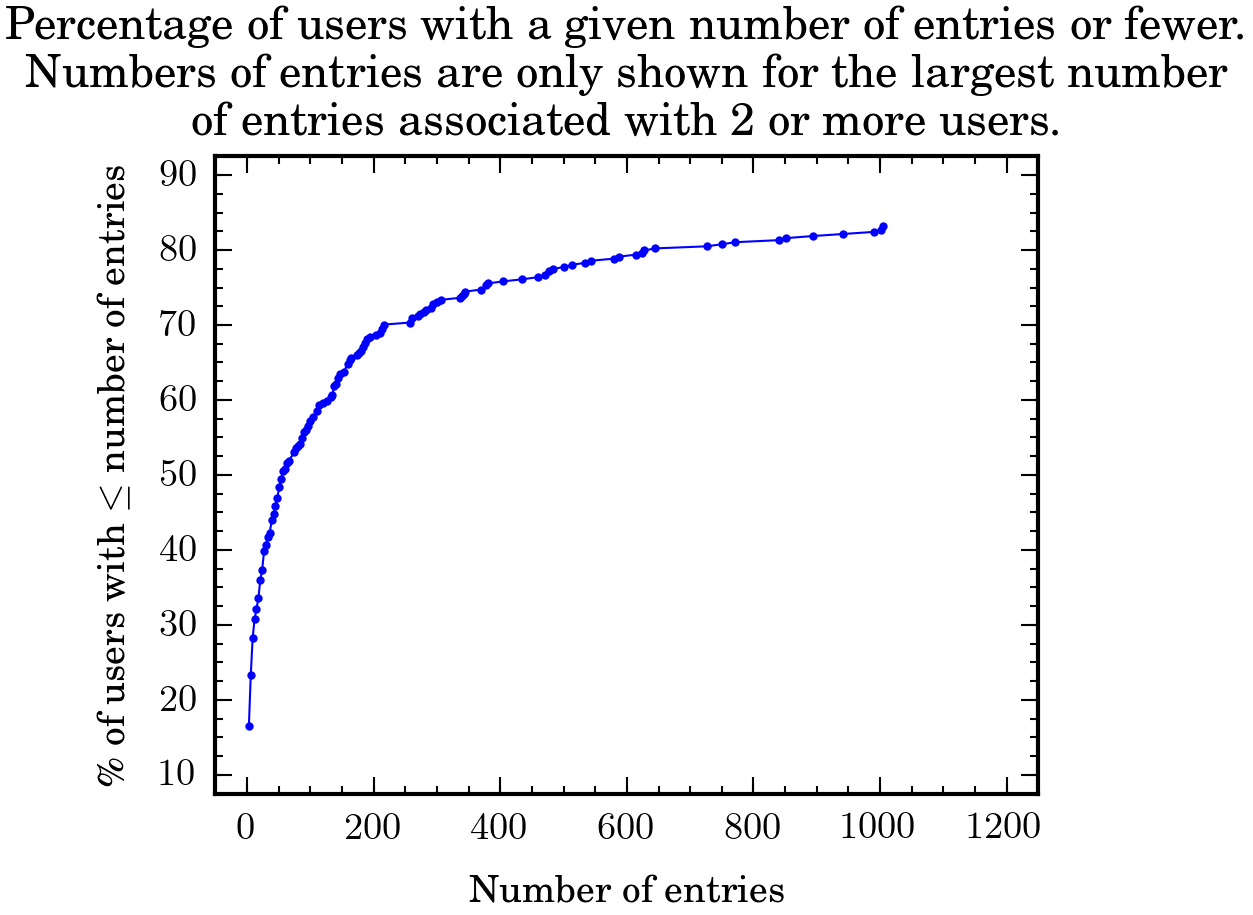

In [6]:
%run entry_count_hist.py

import IPython.display as disp
disp.Image('entry_count.png', width=500)

There are 60 users with only one entry. About 28% of users have 3 or fewer entries, and about 50% of users have 19 or fewer entries.

## Additional Ideas or Observations

### Users with "bot" or "aut" in their names (mongo shell)

It was noticed that 2 of the 10 users with the largest number of posts had "bot" in their names. These are likely automated entries or fixes. Therefore a search for users with "bot" or "aut" (short for "automatic" or "automated") was performed.

> db.Baton_Rouge_LA_US_area.aggregate( [ { \$match: { "created.user": /.\*bot.\*/ } }, { \$group: { _id: "\$created.user", count: { \$sum: 1} } }, { \$sort: { "count": -1 } } ] )

>> { "_id" : "woodpeck_fixbot", "count" : 57387 }

>> { "_id" : "bot-mode", "count" : 8820 }

>>{ "_id" : "xybot", "count" : 18 }

> db.Baton_Rouge_LA_US_area.aggregate( [ { \$match: { "created.user": /.\*aut.\*/ } }, { \$group: { _id: "\$created.user", count: { \$sum: 1} } }, { \$sort: { "count": -1 } } ] )

> db.Baton_Rouge_LA_US_area.aggregate( [ { \$match: { "created.user": /.\*bot.\*/ } }, { \$group: { _id: 1, count: { \$sum: 1} } } ] )

>> { "_id" : 1, "count" : 66225 }

There were 3 users with "bot" in their names, and 0 with "aut" in their names. 66225 of 260134 entries can be contributed to users with "bot" in their names. Therefore it is likely that at least 25% of the entries in the data are automated entries or fixes.

### Correct street names at the point of entry

It seems that having to make corrections to get consistent street names could be avoided if OSM developed some standards for different countries or regions for how streets should be named. Then names could be checked at the point of entry and users might be asked if the correction is right or the changes could be automatic, although automatic changes would still allow for some errors in cases where the correction is not right.

### Use OSM data analyzed at different times and regions to indicate changes in economic health of an area, population change, etc.

OSM data might be trained against other data sets containing estimators of economic health in a region, population in a region, etc. Then the resulting models might be used on a city or region or country divided into pieces at different times to give a rough spatial and temporal view of changes in economic health, population change, etc. The advantage of this would be that the data is totally free to collect. The disadvantages would be that the time lag in the data might be longer than for other data sources and the accuracy may not be as high. 

A measure of population might involve the number of residences, number of apartments, number of total buildings, area occupied by residences, area occupied by apartments, area occupied by all buildings, number of nodes per area (node density), or area with a certain minimum node density. A problem with many of these quantities is that they can change not only because of changing population, but also due to more data being added on existing structures independent of population. Thus, this might only work for areas where there is already a lot of data and most new data added is for new structures.

As an oversimplified example, let's divide the current data set into four pieces and get the total number of buildings in each quadrant. Estimating areas for buildings based on their node references and getting node densities would be more complicated.

In [8]:
%run building_count.py

The data set extends from 29.9078&deg; to 31.5403&deg; latitude and from 91.7301&deg; to -89.3449&deg; longitude. The building counts are shown below. Most of the buildings are in one quadrant while two quadrants have no buildings.

In [9]:
pd.DataFrame(np.column_stack((np.round(boundaries, 2), building_count)), 
             columns=['lat min', 'lat max', 
                      'long min', 'long max', 'bldg count'])

,lat min,lat max,long min,long max,bldg count
0,29.91,30.72,-91.73,-90.54,4056.0
1,29.91,30.72,-90.54,-89.34,0.0
2,30.72,31.54,-91.73,-90.54,6.0
3,30.72,31.54,-90.54,-89.34,0.0


Looking at the building counts by type reveals that the majority of the buildings are uncategorized; they just have the type "yes". Therefore, just using houses or apartments would not be good at least for this area. The "other" type below includes all types except "house", "apartments", and "yes".

In [81]:
building_type_counts_df = pd.DataFrame.from_dict(building_type_counts, 
                                                 orient='index')
building_type_counts_df.columns = ['count']

other_count = np.sum(building_count) - \
    np.sum(building_type_counts_df.loc[{'apartments', 'house', 'yes'}])
other_count = pd.DataFrame.from_dict({'other': other_count['count']}, 
                                     orient='index')
other_count.columns = ['count']

building_type_counts_df.append(other_count).loc[{'apartments', 'house', 
                                                 'yes', 'other'}]

,count
house,765.0
yes,2634.0
other,567.0
apartments,96.0
